In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#guarantee fixed seeds for comparability
np.random.seed(42)
tf.random.set_random_seed(42)

# Part 1: Tensorflow Basics

Tensorflow is a python library that allows you to conveniently design and optimize complicated parameterized computational flows while taking away most of the effort to specify the technical aspects of parallel computing by hand.

It consists of a `graph` of computation nodes, that depend on each other and together represent a function.

To maintain a state within this graph (needed to represent functions that possess parameters that can be tuned) the execution runtime is captured within a `session`. The `session` maintains the state of parameters and allows for executing the graph as a regular function given its inputs.

### Simple computation flow specification and execution

First we create an empty tensorflow graph

In [3]:
graph = tf.Graph()

Then we bind a session to this graph

In [4]:
# this line opens a context in which all following tensorflow operations are bound to the graph
with graph.as_default():
    session = tf.Session()

Add a simple computation flow $c \gets a + b$ to the session's graph

In [5]:
with graph.as_default():
    
    # create two constants a and b
    a = tf.constant([1.], name="a")
    b = tf.constant([3.], name="b")
    
    # c is the node resulting from adding a and b
    c = a + b

__Keep in mind__: all tensorflow operations (ops) yield computation nodes with dependencies. 

They do not equate with the computed value. 

Ops have to be seen as objects that emit an output message once they obtain messages to all of their inputs.

In [6]:
print(f"a: {a}")
print(f"b: {b}")
print(f"c: {c}")

# we can always peek into the inputs that are required to compute the value of a node
print(f"parents of c: {list(c.op.inputs)}")

a: Tensor("a:0", shape=(1,), dtype=float32)
b: Tensor("b:0", shape=(1,), dtype=float32)
c: Tensor("add:0", shape=(1,), dtype=float32)
parents of c: [<tf.Tensor 'a:0' shape=(1,) dtype=float32>, <tf.Tensor 'b:0' shape=(1,) dtype=float32>]


Our graph is completely determined by the nodes $c \gets a + b$, $a \gets 1$, $b \gets 3$.

Now the output node $c$ within our session

In [7]:
# again ensure that we use the right graph
with graph.as_default():
    
    # execute the node c (including all its dependencies) and store its result
    c_output = session.run(c)
    
# the result is now a numpy array
c_output

array([4.], dtype=float32)

### Interacting with the graph 

Right now we cannot add arguments to the function represented by our computation graph. This can be remedied by adding _placeholders_.

In [8]:
# again ensure that we use the right graph
with graph.as_default():
    
    # add a placeholder op d to the graph that we can later feed with values when executing the graph
    # i.e. by calling session.run(...)
    d = tf.placeholder(dtype=tf.float32, shape=(), name="d")
    
    # we can use placeholders in the same way as other ops
    e = c + d

In [9]:
print(f"d: {d}")
print(f"e: {e}")
print(f"parents of e: {list(e.op.inputs)}")

d: Tensor("d:0", shape=(), dtype=float32)
e: Tensor("add_1:0", shape=(1,), dtype=float32)
parents of e: [<tf.Tensor 'add:0' shape=(1,) dtype=float32>, <tf.Tensor 'd:0' shape=() dtype=float32>]


If an op within a graph possesses inputs that are placeholders those have to be fed with values in order to be able to execute the graph. 

Values for placeholders are fed to the graph, by giving a `feed_dict` as an argument to `session.run(...)`. 

The `feed_dict` is a regular python dictionary, where the keys are given by the required placeholders and the values by the values that are to be assigned to those.

If a placeholder is part of a dependency and yet unassigned tensorflow will throw an exception. 

You can reproduce this by removing the `feed_dict={...}` argument from the `session.run(...)` below.

In [10]:
# again ensure that we use the right graph
with session.graph.as_default():
    
    # execute the node e by setting the placeholder d to be 38
    e_output = session.run(e, feed_dict={d: 38})
    
print(e_output)

[42.]


### Adding Variables

Tensorflow allows to assign parameters to a computation graph, which parameterize the behavior of the represented functions.

Parameters can then, e.g., be optimized such that the represented function minimizes a loss.

In [11]:
# again ensure that we use the right graph
with graph.as_default():
    
    # add a named variable f to the graph that is by default initialized to a constant
    f = tf.get_variable("f", shape=(), initializer=tf.initializers.constant(38.))
    
    # variables are again usable in the same way as any other op
    g = c + f

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
print(f"f: {f}")
print(f"g: {g}")
print(f"parents of g: {list(g.op.inputs)}")

f: <tf.Variable 'f:0' shape=() dtype=float32_ref>
g: Tensor("add_2:0", shape=(1,), dtype=float32)
parents of g: [<tf.Tensor 'add:0' shape=(1,) dtype=float32>, <tf.Tensor 'f/read:0' shape=() dtype=float32>]


Similarily as with the placeholders any variable that is input to another op has to possess a set value before this op can be evaluated. This can be done by calling the `initializer` of the variable. 

While doing this explicitly is possible, it would be quite tedious for complicated graphs. 

Thus, tensorflow allows for simultaneously initializing all variables in the graph at once.

If a variable is not initialized before a dependent op is executed tensorflow will throw an exception. You can reproduce this, by commenting out
```
    initializer = tf.global_variables_initializer()
    session.run(initializer)
```
in the code snippet below (if this has already been executed, you might need to restart the notebook to see the effect).

In [13]:
# again ensure that we use the right graph
with graph.as_default():
    
    # create an initializer op in the graph
    # if the initializer is executed it will initialize all variables in the graph
    # with their respective initializer op
    initializer = tf.global_variables_initializer()
    session.run(initializer)
    
    # now that all variables have a value set we can evaluate g as well
    g_output = session.run(g)

g_output

array([42.], dtype=float32)

### Reusing Variables

Once a variable is defined, it is bound to its name and another variable with the same name
cannot be created.

In [14]:
with graph.as_default():
    try:
        f = tf.get_variable("f", shape=(), initializer=tf.initializers.constant(38.))
    except ValueError:
        print("Could not create \"f\".")

Could not create "f".


To share variables, either the `tf.Variable` instance can be passed explicitly
or it can be wrapped within a `tf.variable_scope`. The latter can be handy when
defining functions that should be reused.

In [15]:
def my_layer(inputs):
    my_var = tf.get_variable("my_var", shape=(), initializer=tf.initializers.constant(38.))
    return inputs + my_var


with graph.as_default():
    output = my_layer(f)
    try:
        output = my_layer(output)
    except ValueError:
        print("This fails because TensorFlow does not know whether to reuse or recreate the variable.")

This fails because TensorFlow does not know whether to reuse or recreate the variable.


In [16]:
def my_layer_with_reuse(inputs, reuse=False):
    with tf.variable_scope("my_layer", reuse=reuse):
        my_var = tf.get_variable("my_var_with_reuse", shape=(), initializer=tf.initializers.constant(38.))
        print(f"Got variable {my_var}")
    return inputs + my_var


with graph.as_default():
    output = my_layer_with_reuse(f)
    try:
        output = my_layer_with_reuse(output, True)
    except ValueError:
        print("This fails because TensorFlow does not know whether to reuse or recreate the variable.")

Got variable <tf.Variable 'my_layer/my_var_with_reuse:0' shape=() dtype=float32_ref>
Got variable <tf.Variable 'my_layer/my_var_with_reuse:0' shape=() dtype=float32_ref>


Here we had to specify whether to reuse the variable explicitly. Per default,
TensorFlow will create the variable if it did not exist and otherwise reuse it
in a `variable_scope`:

In [17]:
def my_layer_with_reuse(inputs):
    with tf.variable_scope("my_layer", reuse=tf.AUTO_REUSE):
        my_var = tf.get_variable("my_var2", shape=(), initializer=tf.initializers.constant(38.))
        print(f"Got variable {my_var}")
    return inputs + my_var


with graph.as_default():
    output = my_layer_with_reuse(f)
    output = my_layer_with_reuse(output)

Got variable <tf.Variable 'my_layer/my_var2:0' shape=() dtype=float32_ref>
Got variable <tf.Variable 'my_layer/my_var2:0' shape=() dtype=float32_ref>


# Part 2: Linear Regression

Now lets make something usable: [Linear Regression](https://en.wikipedia.org/wiki/Linear_regression)!

A linear model is a function  $f_{W} \colon \mathbb{R}^{d_1} \rightarrow \mathbb{R}^{d_2}$ given by

$$ f_W(x) = Wx $$

where the data matrix $W \in \mathbb{R}^{d_2 \times d_1}$ holds the _parameters_ of the model.

Before we can fit something, we need to generate data:

Our ground truth is given by a simple 1D harmonic function, which cannot be properly represented by linear function. However, we can try to find the best possible fit.

This means in our case we have $d_1 = 2$ and $d_2 = 1$ with $W = (b, w)$ and $x = (1, x_0)^T$.

In [18]:
def ground_truth(x):
    return np.sin(x) - np.cos(1.9 * x)

We generate some samples from our model and add some artificial measurement noise. This is the data that we observe from the ground truth.

In [19]:
n_samples = 30
noise_level = 0.3

xs_data = np.random.uniform(low=-np.pi, high=np.pi, size=(n_samples, 1))
ys_data = ground_truth(xs_data) + noise_level * np.random.normal(size=xs_data.shape)

Plot the samples and the ground truth

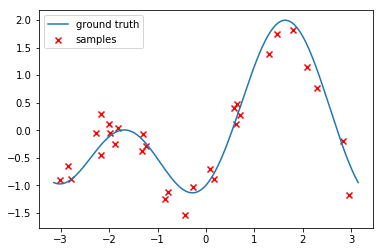

In [20]:
xs = np.linspace(-np.pi, np.pi, 300)[:, np.newaxis]
ys = ground_truth(xs)

plt.plot(xs, ys, label="ground truth")
plt.scatter(xs_data, ys_data, marker="x", c="r", label="samples")
plt.legend()

### Specifying the graph

Create an empty graph and a tensorflow session for this graph.

In [21]:
graph = tf.Graph()

with graph.as_default():
    session = tf.Session()

We start with defining the linear function. Its input is a placeholder name `data_input`, its output is the node `model_output`.

We need to choose an `initializer` for the variables `weight` and `bias`. A common choice is to use Gaussian noise for the first and set the second to zero.

In [22]:
with graph.as_default():
    
    data_input = tf.placeholder(dtype=tf.float32, shape=(None, 1), name="data_input")
    
    with tf.variable_scope("linear_model"):
        weight = tf.get_variable(name="weight", shape=(1, 1), dtype=tf.float32, 
                            initializer=tf.initializers.random_normal())
        bias = tf.get_variable(name="bias", shape=(1, 1), dtype=tf.float32, 
                            initializer=tf.initializers.zeros())
        model_output = weight * data_input + bias

In order to optimize the model to fit our data, we have to specify an optimization criterion. In our case we aim to minimize the mean squared error of our model $f_W = f_{w, b}$ on the observed data $(x_n, y_n), ~ n \in [N]$ with respect to the parameters $w, b$:

$$w_{*}, b_{*} = \arg\min_{w, b} \tfrac{1}{N} \sum_{n=1}^{N}(f_{w, b}(x_i) - y_i)^{2}$$

We feed in the targets $y_n$ using another placeholder `target_input`.

In [23]:
with graph.as_default():
    
    target_input = tf.placeholder(dtype=tf.float32, shape=(None, 1), name="target_input")
    
    loss = tf.losses.mean_squared_error(target_input, model_output)

Instructions for updating:
Use tf.cast instead.


Now we have to specify the optimization procedure. 

In our case we use simple [Gradient Descent](https://en.wikipedia.org/wiki/Gradient_descent) with fixed step size parameter (in tensorflow it is called `learning_rate`).

This will also be specified within the graph.

In [24]:
with graph.as_default():
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=1e-3)
    optimization_step = optimizer.minimize(loss)

Now that model, loss and optimization routine is set up, we can initialize all variables of the model in order to start the training.

In [25]:
with graph.as_default():
    
    initializer = tf.global_variables_initializer()
    session.run(initializer)

Now that the `weight` and the `bias` have their initial values, we can show what the model predicts. 

Initially we should not assume that it yields anything useful.

In [26]:
with graph.as_default():
    
    predictions = session.run(model_output, feed_dict={
        data_input: xs
    })
    prediction_on_samples = session.run(model_output, feed_dict={
        data_input: xs_data
    })

Let's compare the prediction on the data set:

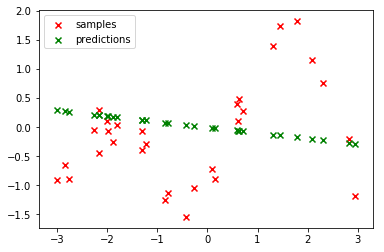

In [27]:
plt.scatter(xs_data, ys_data, marker="x", c="r", label="samples")
plt.scatter(xs_data, prediction_on_samples, marker="x", c="g", label="predictions")
plt.legend();

Now let's see what the model does on the whole domain $[-\pi, \pi]$

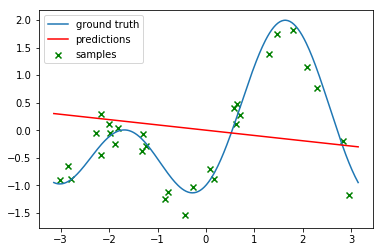

In [28]:
plt.plot(xs, ys, label="ground truth")
plt.plot(xs, predictions, c="r", label="predictions")
plt.scatter(xs_data, ys_data, marker="x", c="g", label="samples")
plt.legend();

As seen above this initial model does not know anything about the data yet and consequently remains very useless.

We remedy this by training it on our observed data.

In [29]:
# numbers of iterations that we pass through the data
n_iteration_steps = 20000

# we store the losses for each training iteration here
losses = []

In [30]:
with session.graph.as_default():
    
    for i in range(n_iteration_steps):

        # we can evaluate multiple nodes at the same time, by putting them in a container like
        # a python list or tuple
        current_loss, _ = session.run([loss, optimization_step], feed_dict={
            data_input: xs_data,
            target_input: ys_data
        })
        
        losses.append(current_loss)

        # we don't want to print the loss at each iteration
        if i % 2000 == 0:
            print(f"iteration: {i}, loss: {current_loss}")

iteration: 0, loss: 0.9046539068222046
iteration: 2000, loss: 0.6065057516098022
iteration: 4000, loss: 0.6065055727958679
iteration: 6000, loss: 0.6065056324005127
iteration: 8000, loss: 0.6065056324005127
iteration: 10000, loss: 0.6065056324005127
iteration: 12000, loss: 0.6065056324005127
iteration: 14000, loss: 0.6065056324005127
iteration: 16000, loss: 0.6065056324005127
iteration: 18000, loss: 0.6065056324005127


The optimization problem is [convex](https://en.wikipedia.org/wiki/Convex_optimization). 

So we can expect the loss to shrink smoothly.

Text(0.5, 0, 'iterations')

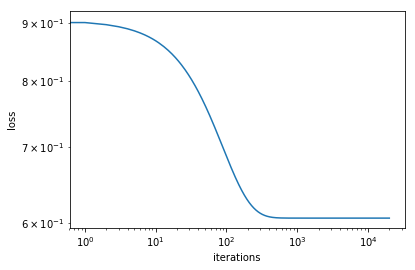

In [31]:
plt.loglog(losses);
plt.ylabel("loss")
plt.xlabel("iterations")

Now lets look again on the model's predictions.

In [32]:
with session.graph.as_default():
    predictions = session.run(model_output, feed_dict={data_input: xs})
    prediction_on_samples = session.run(model_output, feed_dict={data_input: xs_data})

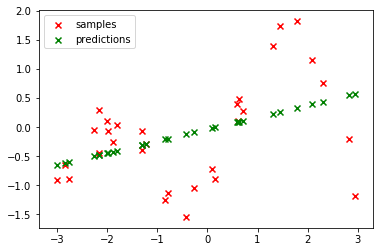

In [33]:
plt.scatter(xs_data, ys_data, marker="x", c="r", label="samples")
plt.scatter(xs_data, prediction_on_samples, marker="x", c="g", label="predictions")
plt.legend()

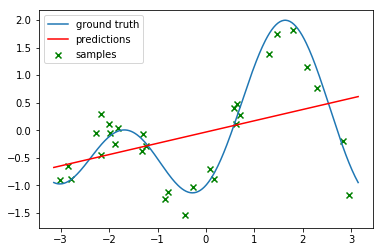

In [34]:
plt.plot(xs, ys, label="ground truth")
plt.plot(xs, predictions, c="r", label="predictions")
plt.scatter(xs_data, ys_data, marker="x", c="g", label="samples")
plt.legend()

We can see that the fit is much better now.

But obviously the linear model is not flexible enought to really capture the ground truth very well.

# Part 3: Homework - kernel ridge regression

### More complicated functions using feature space embeddings

To expand the feature space the data can elevated by transforming it with a function $\varphi : \mathbb{R}^d \to \mathcal{X}$ to a potentially and usually higher-dimensional space $\mathcal{X}$.

Considering a kernel given by a scalar product $k(x_i, x_j) = \langle\varphi(x_i),\varphi(x_j)\rangle_\mathcal{X}$ one can evaluate scalar products in some feature space without ever visiting it. Knowledge of $\varphi$ is not required, only that it exists. A particular choice of kernel is the RBF (radial basis function) kernel given by

$$
k(x_i, x_j) = \exp\left( - \frac{\| x_i - x_j \|^2_2}{2\sigma^2} \right).
$$

This method is known as the [kernel method](https://en.wikipedia.org/wiki/Kernel_method) or also "kernel trick".

In [35]:
def rbf_expansion(inputs, low: float, high: float, count: int):
    low, high, count = float(low), float(high), int(count)
    assert high > low
    spacing = (high - low) / count
    gamma = 1. / spacing
    
    centers = tf.cast(tf.lin_space(low, high, count), inputs.dtype)
    return tf.exp(-gamma * tf.square(inputs - centers))

In [36]:
n_basis_functions = 1

In [37]:
with graph.as_default():
    data_input = tf.placeholder(dtype=tf.float32, shape=(None, 1), name="data_input")
    embedded_input = rbf_expansion(data_input, -3, 3, n_basis_functions)

In [38]:
with session.graph.as_default():
    embedding = session.run(embedded_input, feed_dict={data_input: xs})

Now the data is in a space with $n_b$ = `n_basis_functions` dimensions and we get
$$
f_{W} \colon \mathbb{R}^{n_b} \rightarrow \mathbb{R}^{1}, x \mapsto Wx + b
$$
with $W\in\mathbb{R}^{1\times n_b}$ and $b\in\mathbb{R}$.

In [39]:
# implement the model
with graph.as_default():
    with tf.variable_scope("kernel_trick_1"):
        weight = tf.get_variable(name="weight", shape=(1, n_basis_functions), dtype=tf.float32,
                                 initializer=tf.initializers.random_normal())
        bias = tf.get_variable(name="bias", shape=(1, 1), dtype=tf.float32,
                               initializer=tf.initializers.zeros())
        model_output = tf.tensordot(embedded_input, tf.transpose(weight), axes=1) + bias

In [40]:
# implement the mean squared error between model output and target input
with graph.as_default():
    target_input = tf.placeholder(dtype=tf.float32, shape=(None, 1), name="target_input")
    rbf_loss = tf.losses.mean_squared_error(target_input, model_output)

### Overfitting and underfitting

### Task 1:
After filling the gaps in the previous section, run on `1`, `2`, `80` RBFs and observe the behavior of the fit.

### Task 2:

The variance of the solution can be decreased by biasing the minimization problem into a direction where the degrees of freedom are kept small, effectively improving the condition of the problem. One particular way of achieving this is called $\ell_2$ or Ridge regularizaion, where the weights are penalized with their $\ell_2$ norm. In particular:

$$a
W^* = \arg\min_{W} \tfrac{1}{N} \sum_{n=1}^{N}(f_{W}(x_i) - y_i)^{2} + \lambda \| W \|_2^2
$$

with $\| x \|_2 = (x_1^2 + \ldots + x_d^2)^{\tfrac{1}{2}}$ and for an appropriate choice of $\lambda\geq 0$.

Implement $\ell_2$ regularization for the RBF embedded fitting problem. A useful method to achieve this is [tf.math.reduce_sum](https://www.tensorflow.org/api_docs/python/tf/math/reduce_sum).

### Task 3:

You are given data from an unknown ground truth in the file `training_data.npz`.

Your task is to build a kernel ridge regression model that approximates the ground truth as close as possible, without overfitting on your data set.

__Hint:__ You can use `validation_data.npz` to validate whether your model might have overfitted on the training data. __But beware__: if you include the validation data in your training (or validate too much) then you will also overfit to it as well and you will not be able to extrapolate!

### Deliverables

1. Evaluate your model on the inputs given in the file `x_test.npy`.
2. Upload your model's prediction as a file `model_outputs.npy`.
3. Upload your notebook used for obtaining your results.

__Disclaimer__: we will take samples of your notebooks to see whether the model you have implemented matches the prediction data you submit. If we discover a mismatch that cannot be explained by floating point error or similar we will consider this homework as failed.

### Load data

In [ ]:
training_data_x = np.load("task/x_train.npy")
training_data_y = np.load("task/y_train.npy")

validation_data_x = np.load("task/x_val.npy")
validation_data_y = np.load("task/y_val.npy")
test_data_x = np.load("task/x_test.npy")

### Save your prediction

In [ ]:
model_outputs = session.run(model_output, feed_dict={data_input: test_data_x})
np.save("model_outputs", model_outputs)